In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataloaders import MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.neurons import IntegrateAndFireNeuron
from spiking.learning.stdp import STDP
from visualization import SpikesVisualization

In [3]:
dataloader = MnistSpikesDataloader("./data/mnist-subset", 'train')
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")


max_input_spikes = 1568


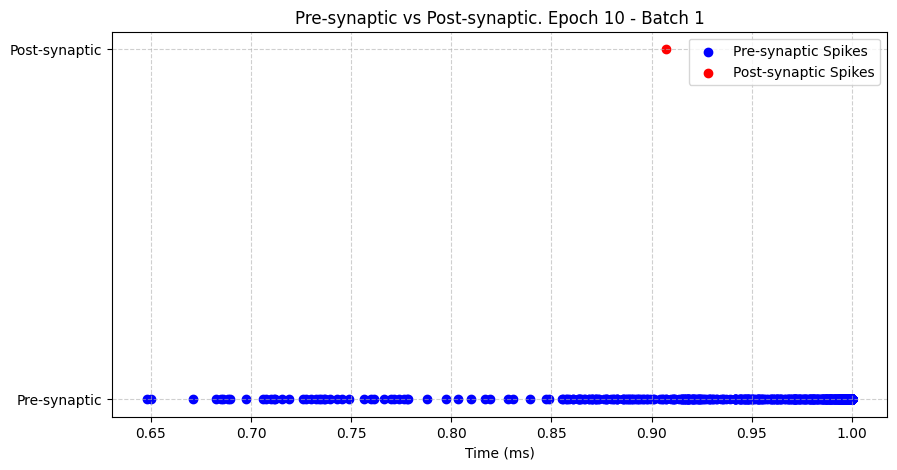

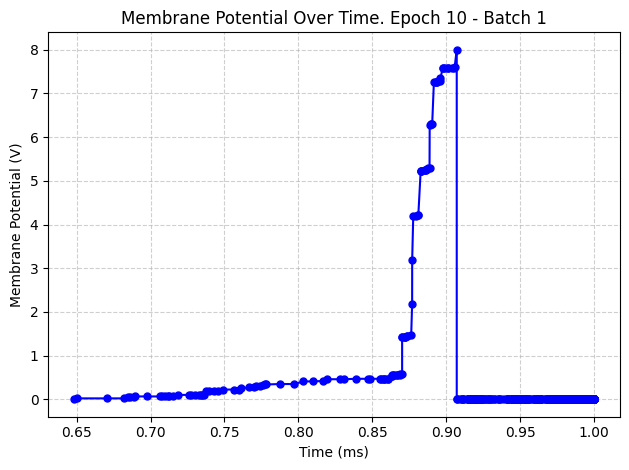

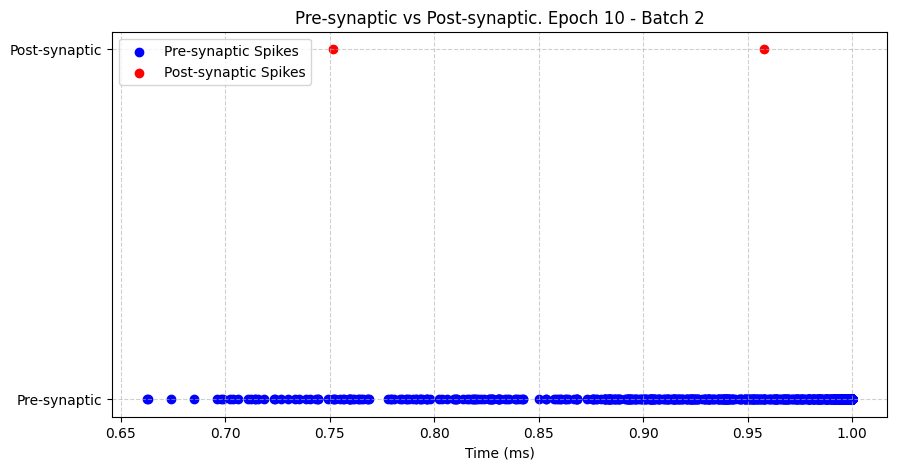

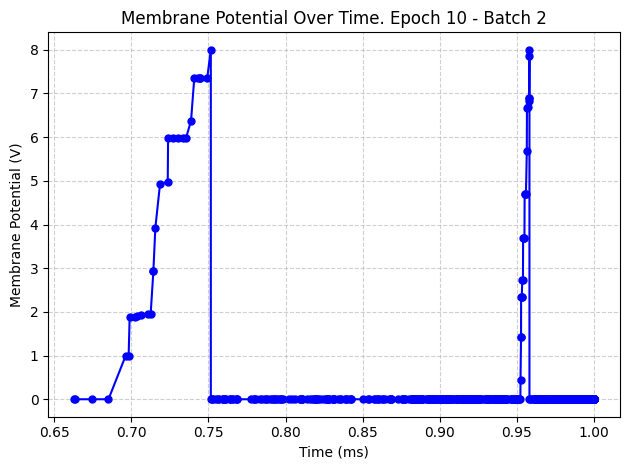

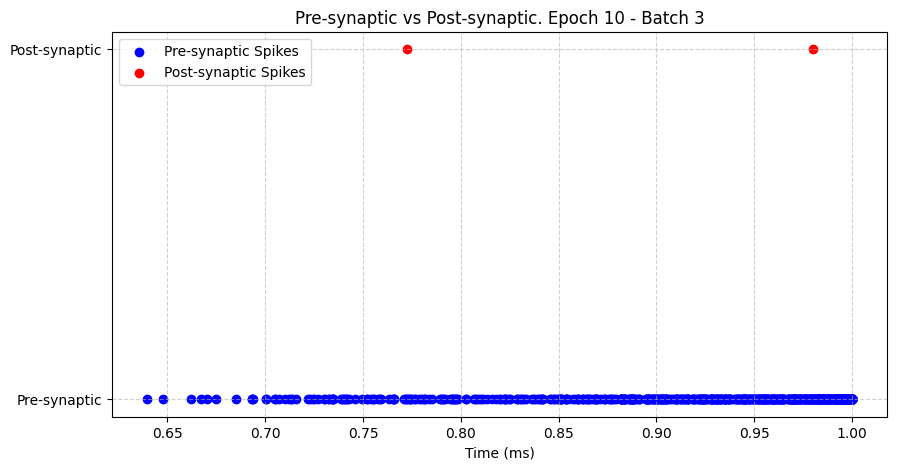

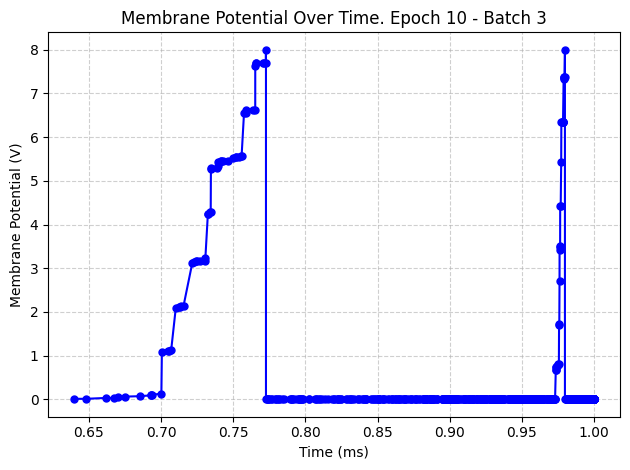

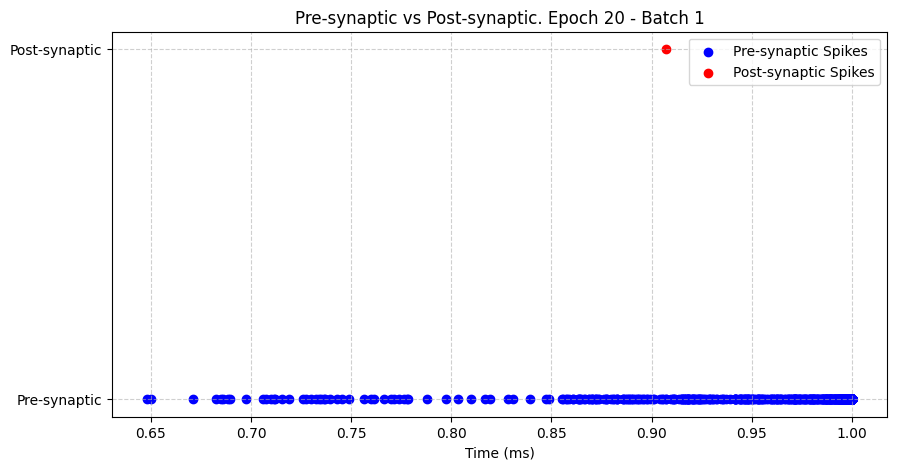

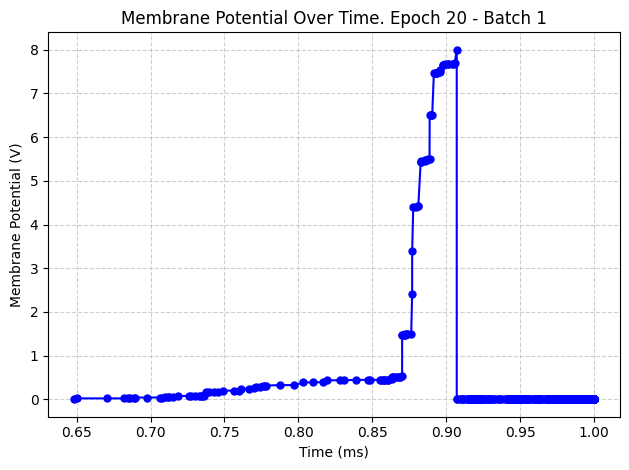

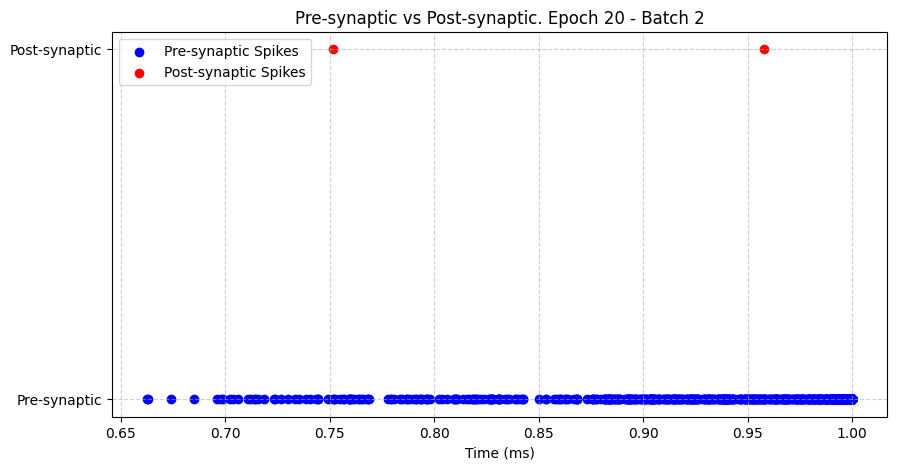

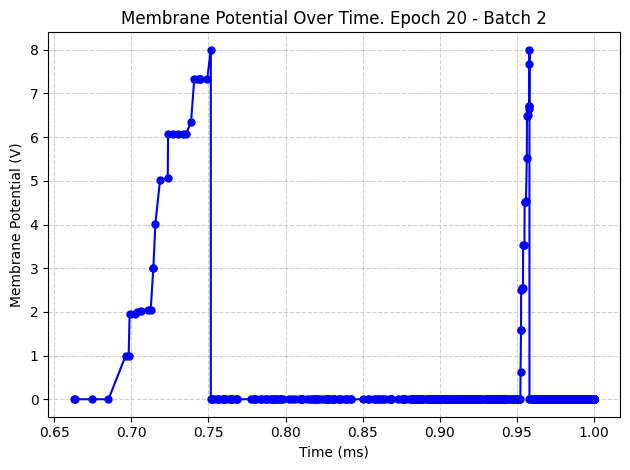

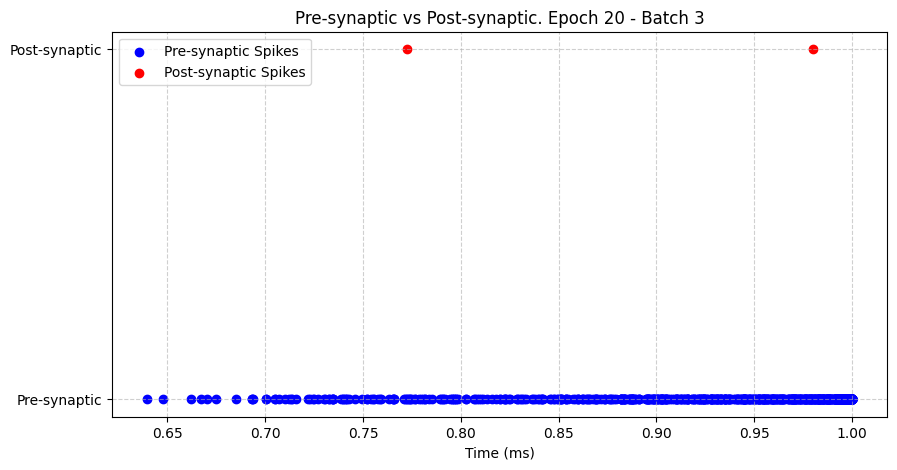

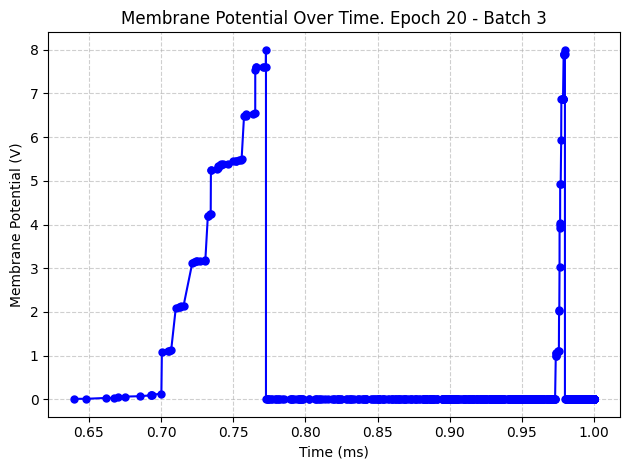

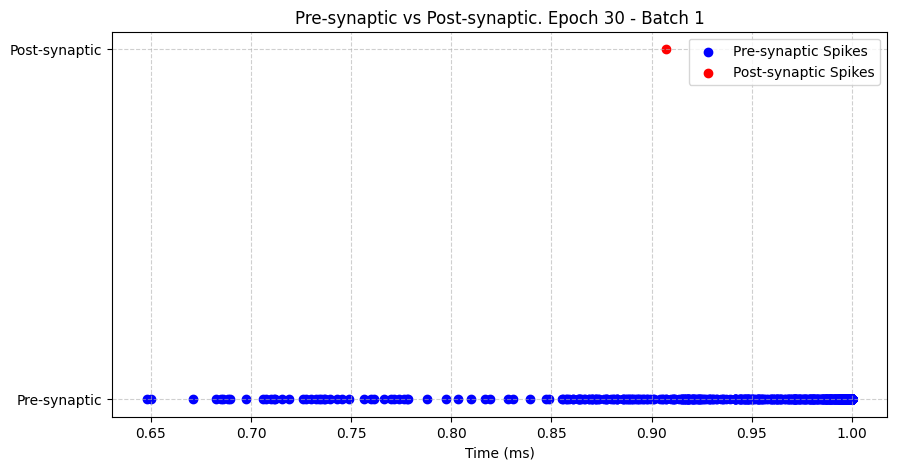

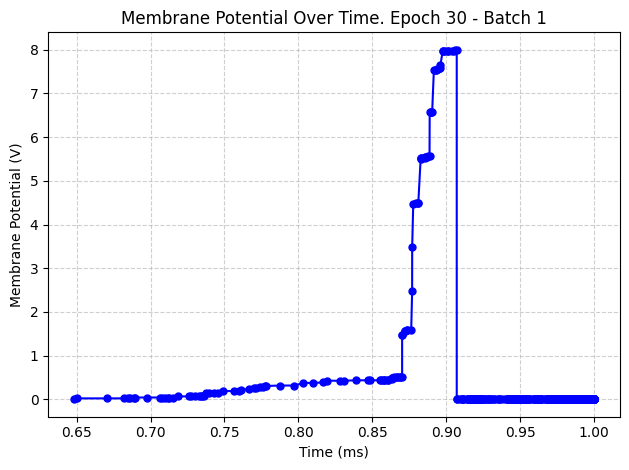

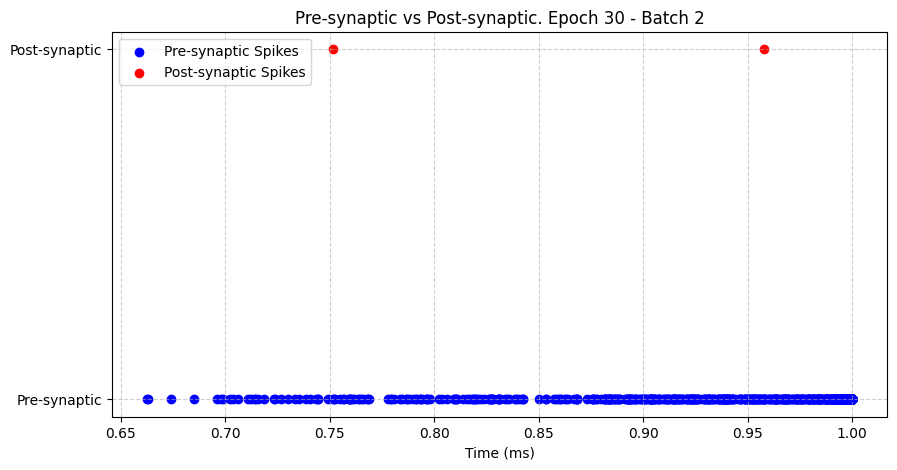

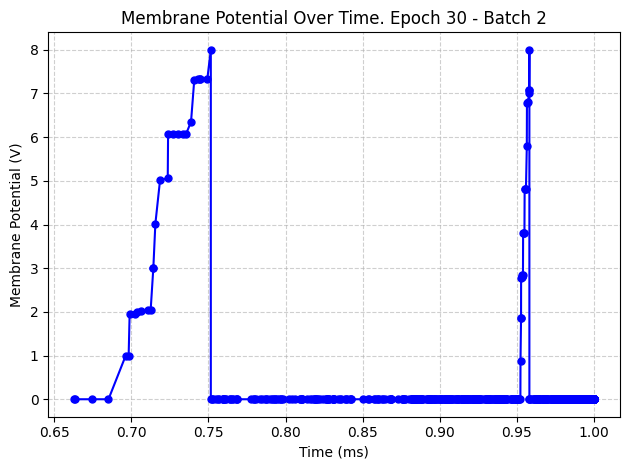

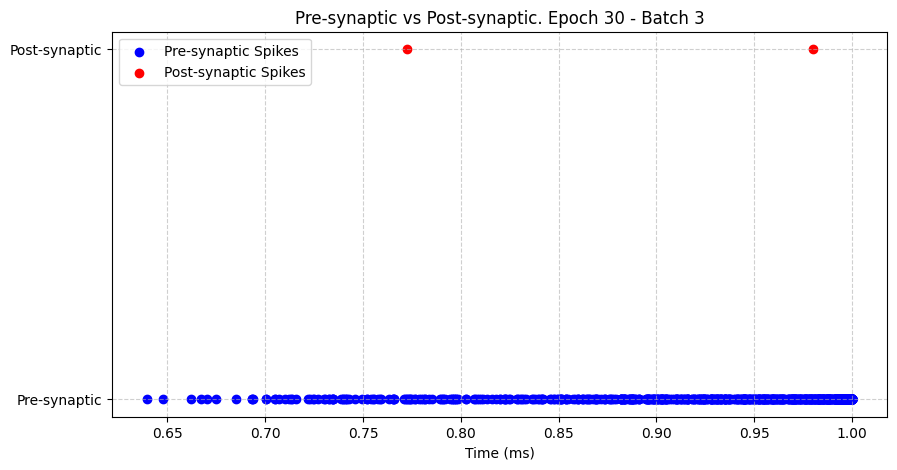

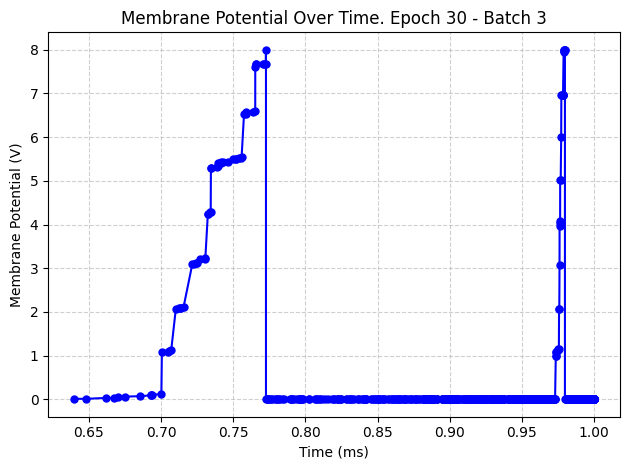

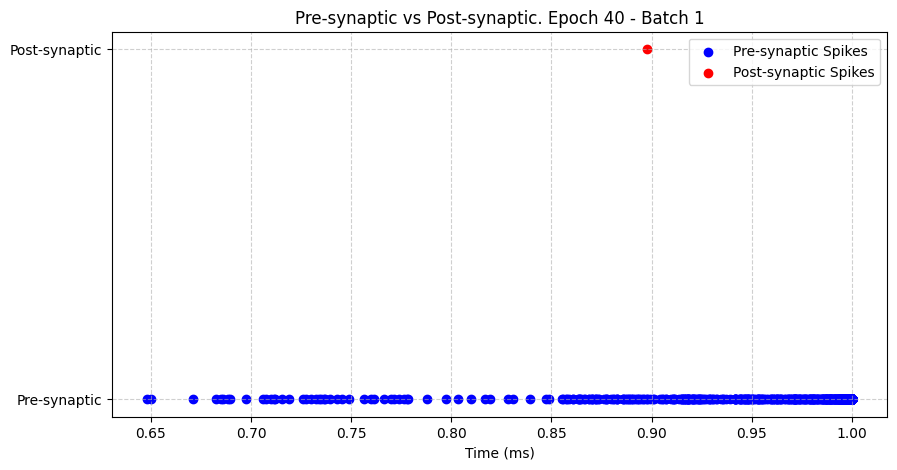

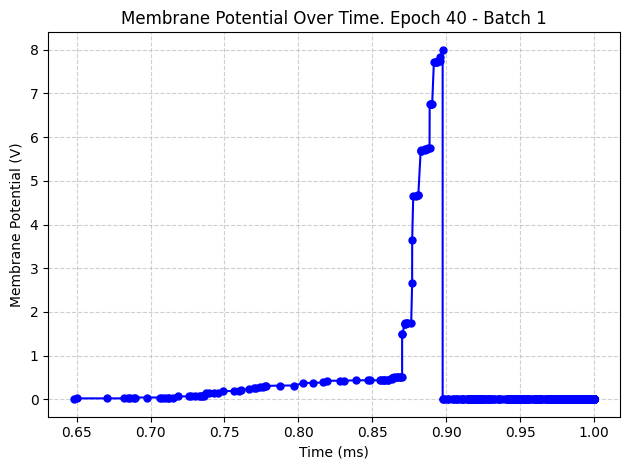

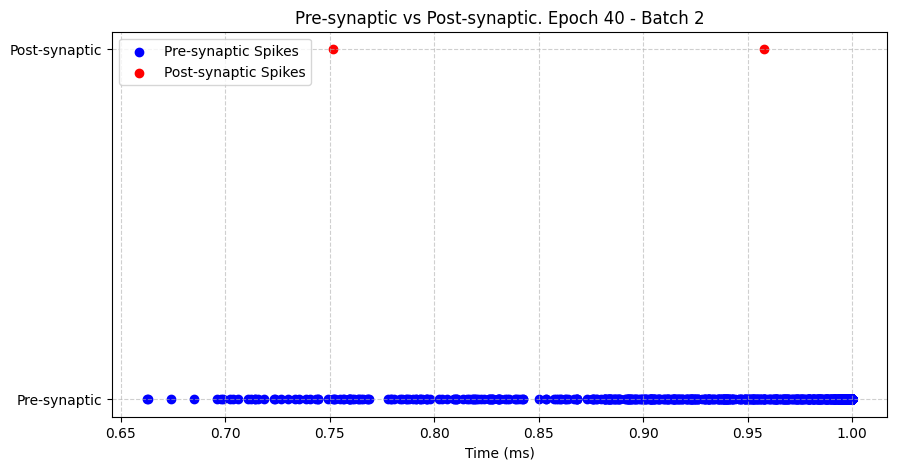

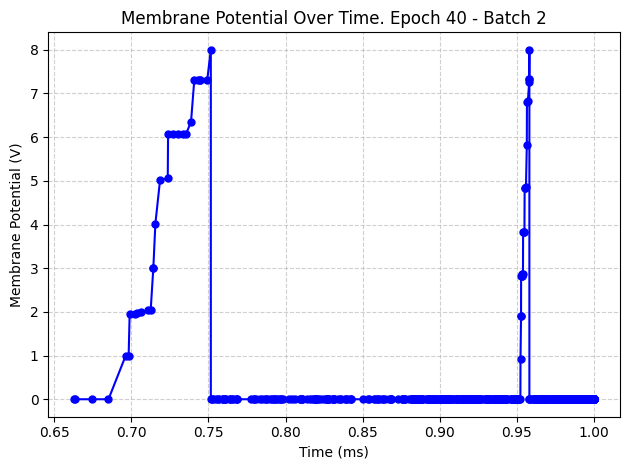

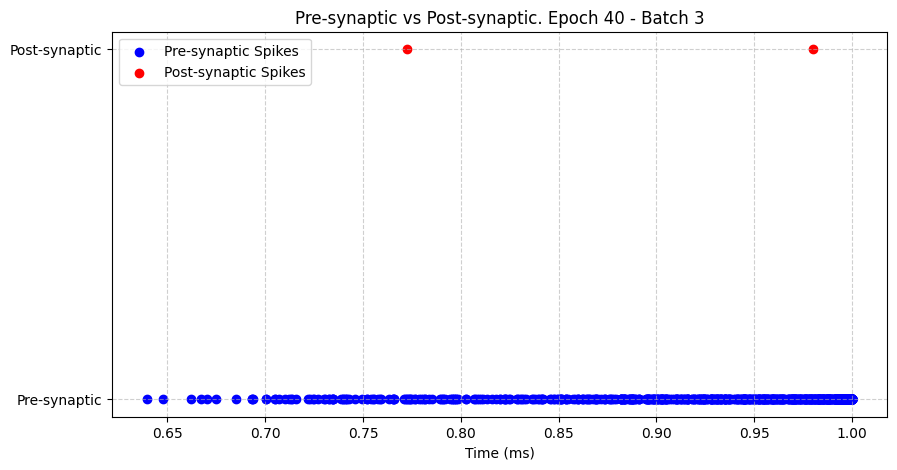

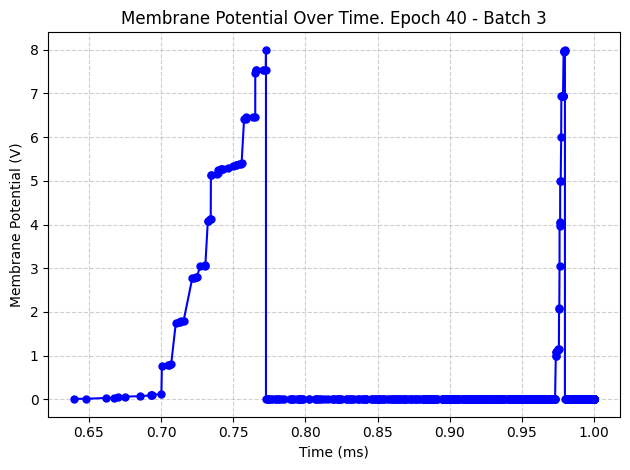

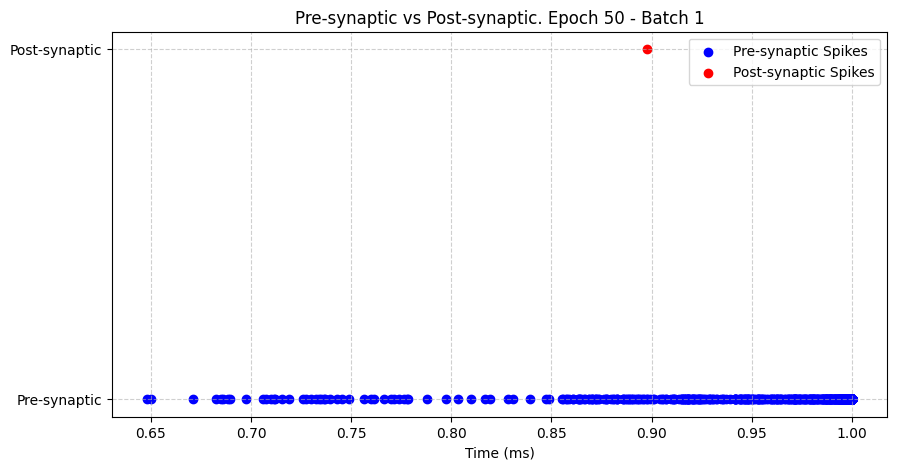

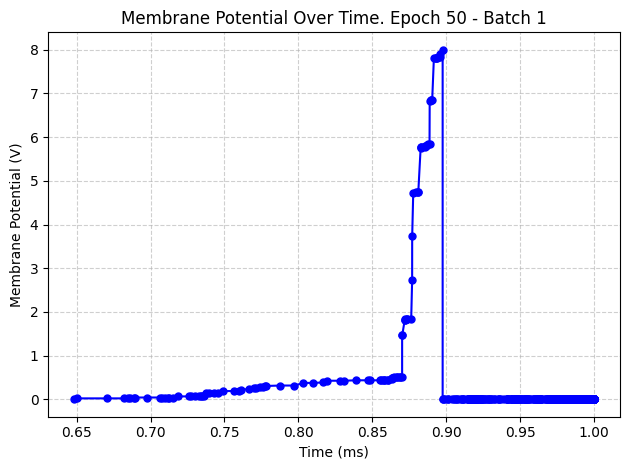

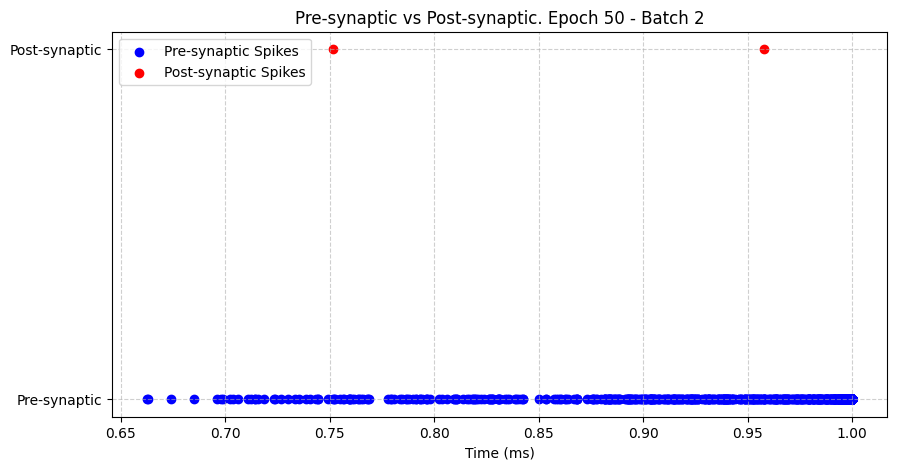

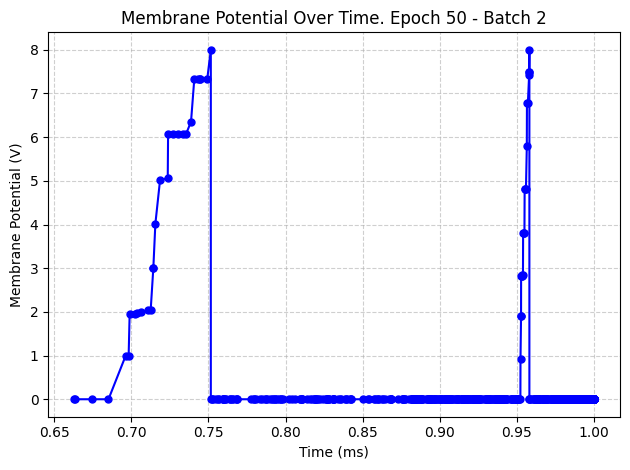

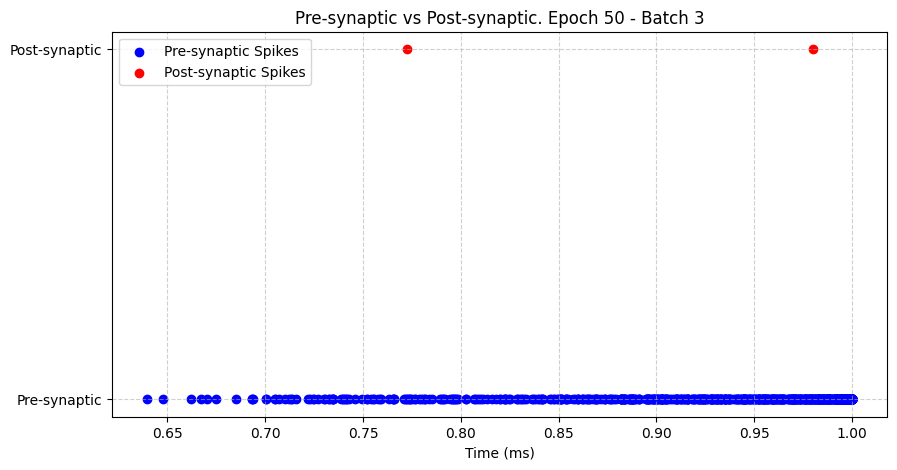

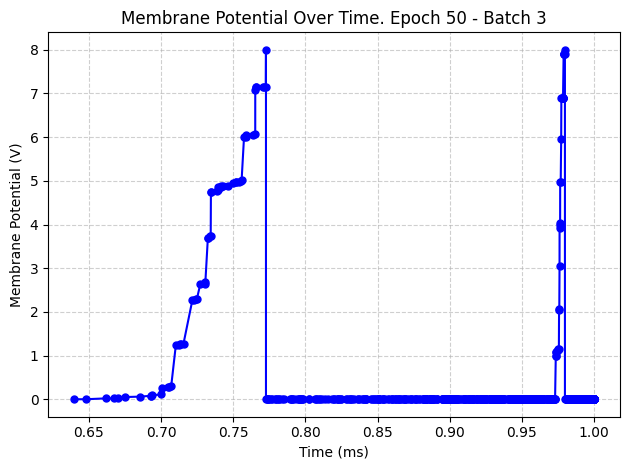

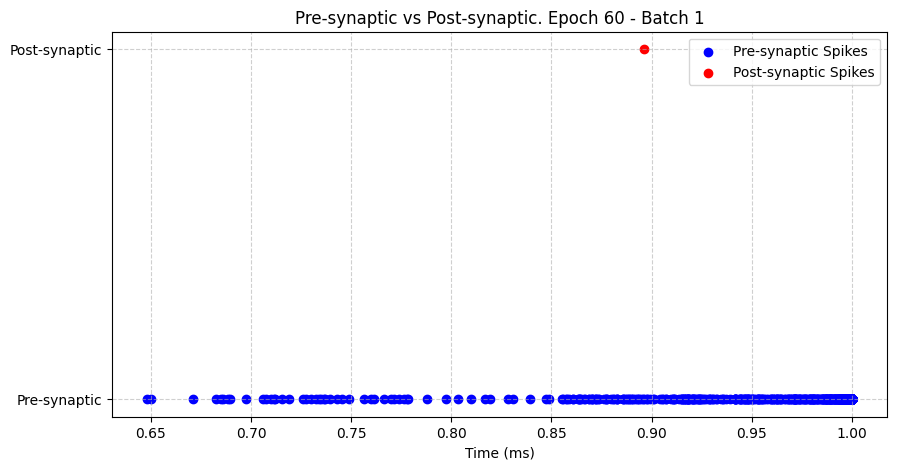

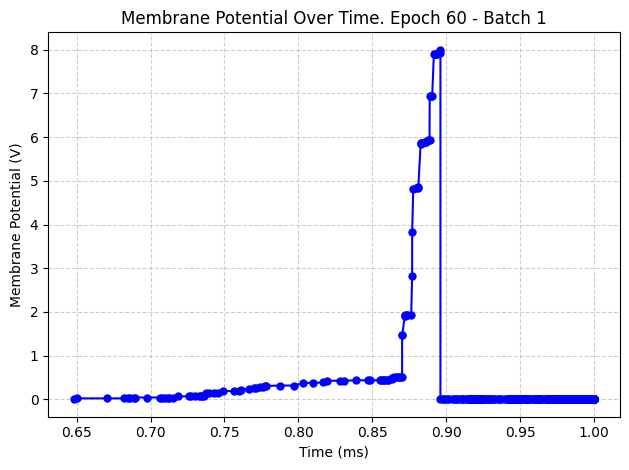

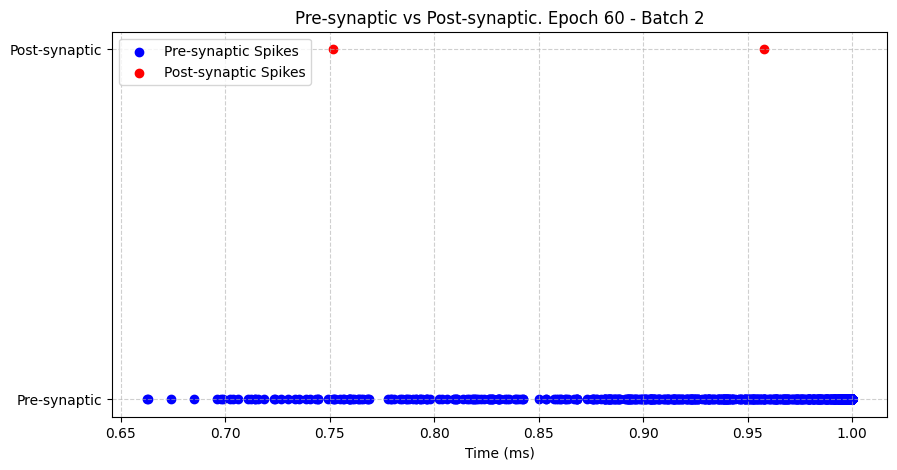

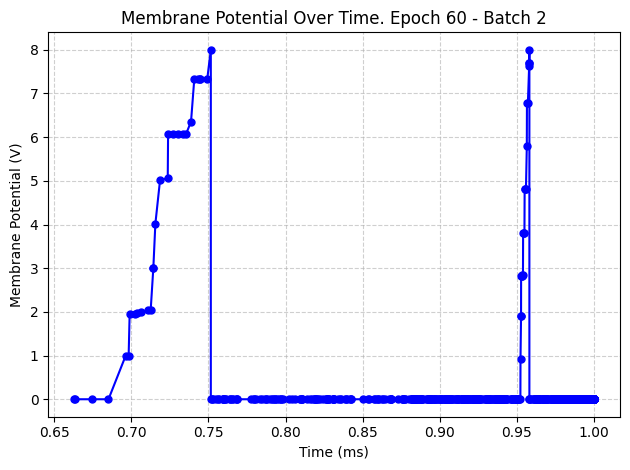

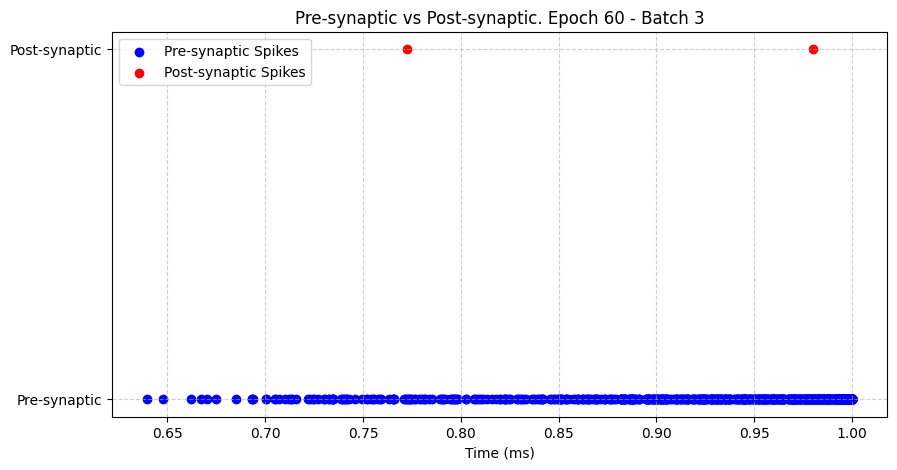

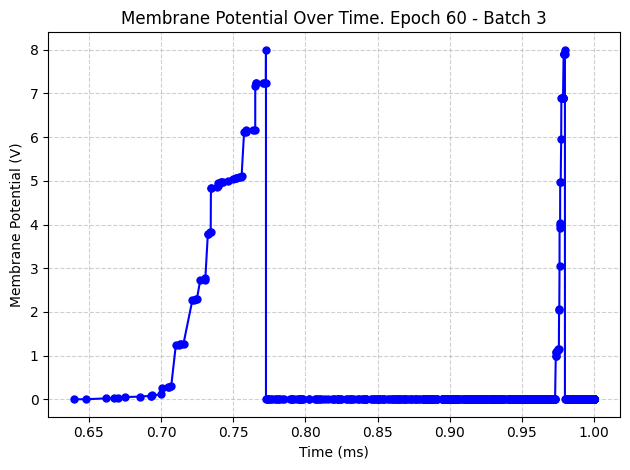

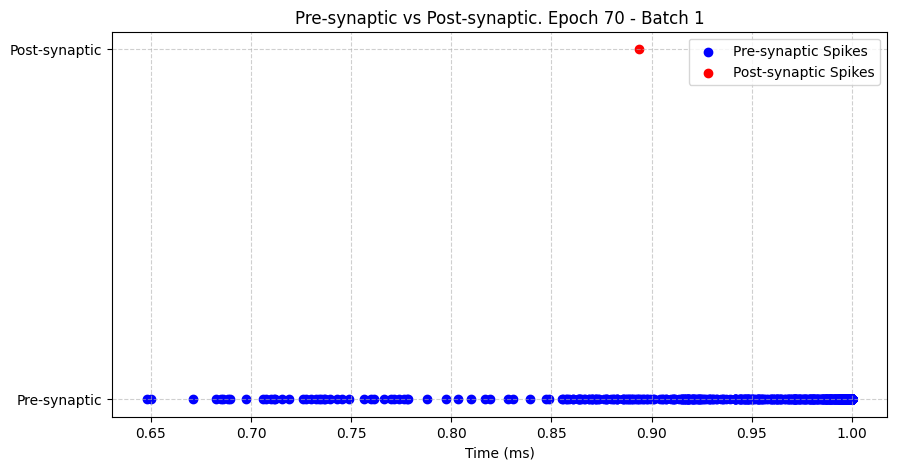

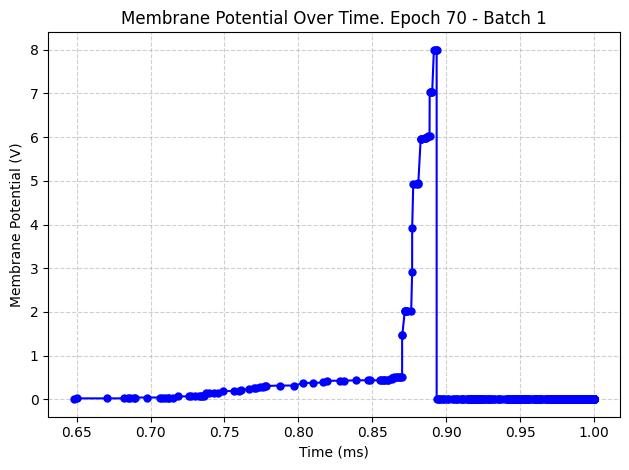

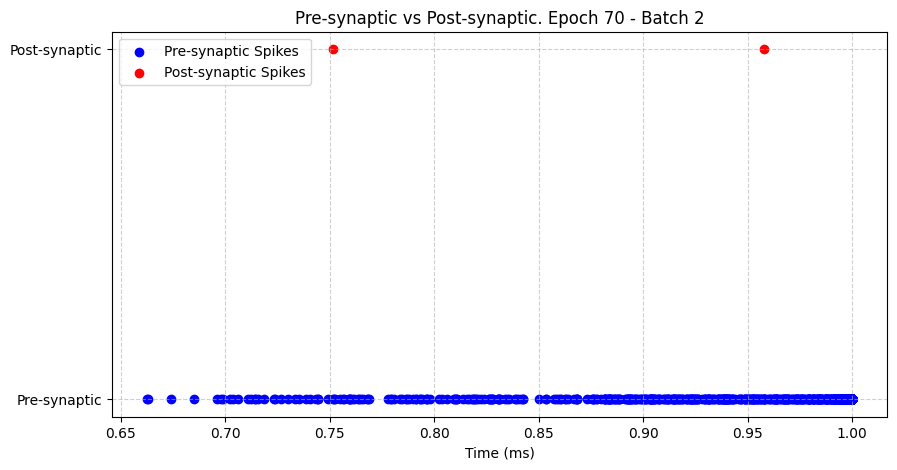

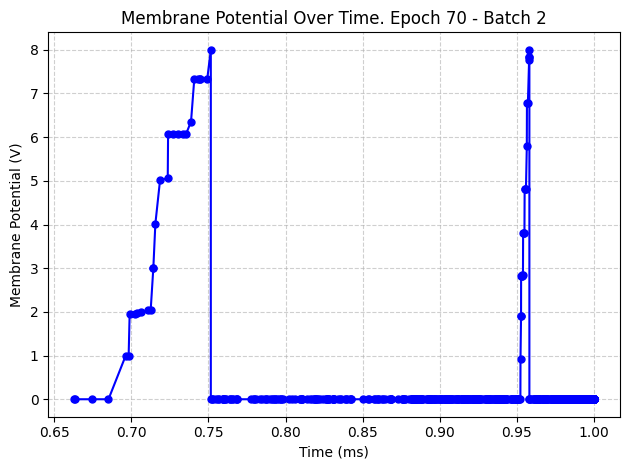

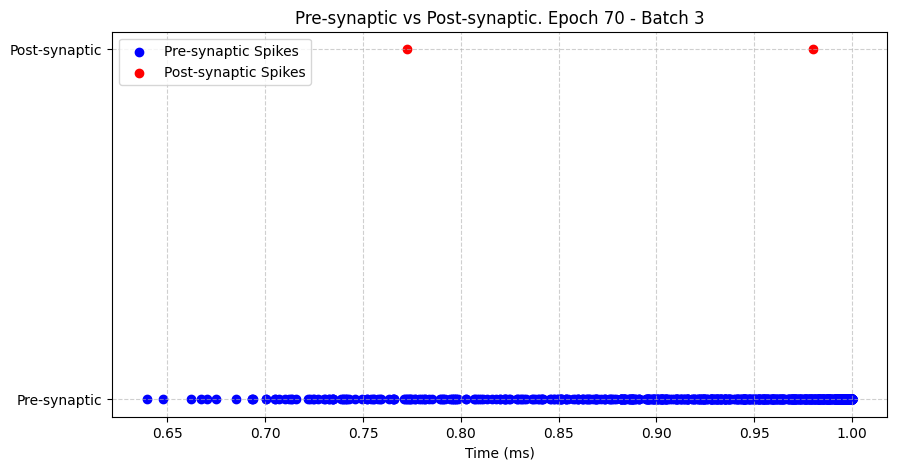

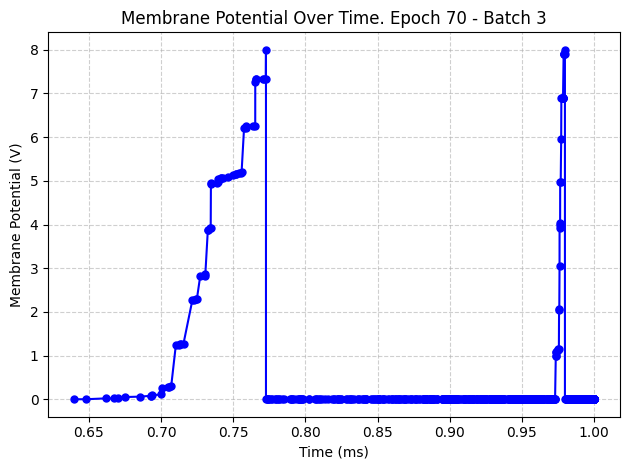

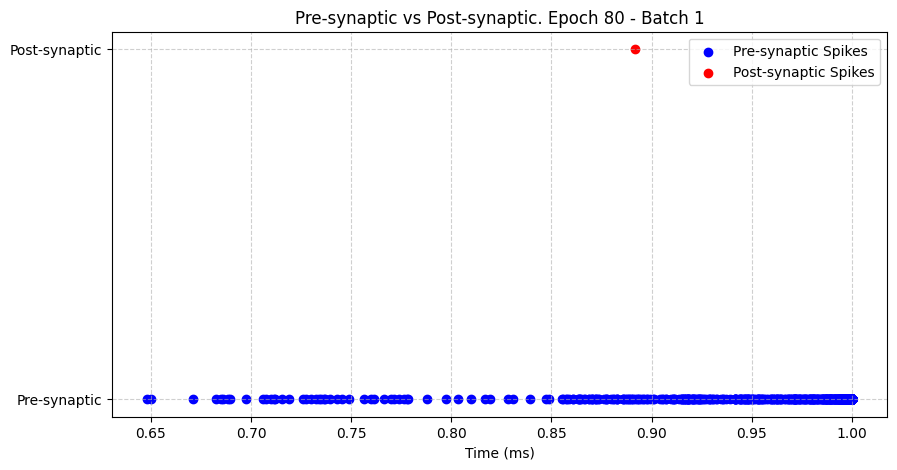

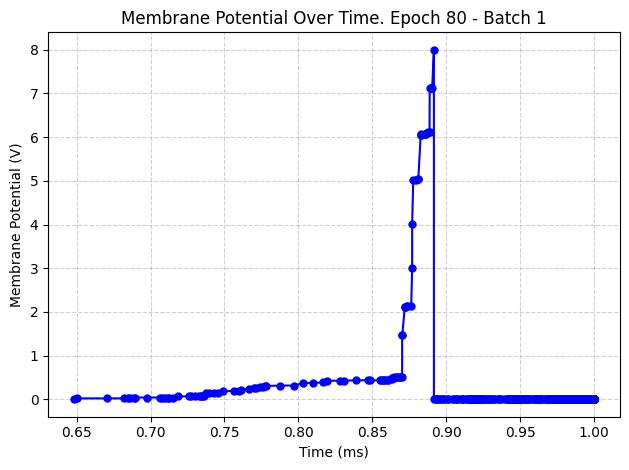

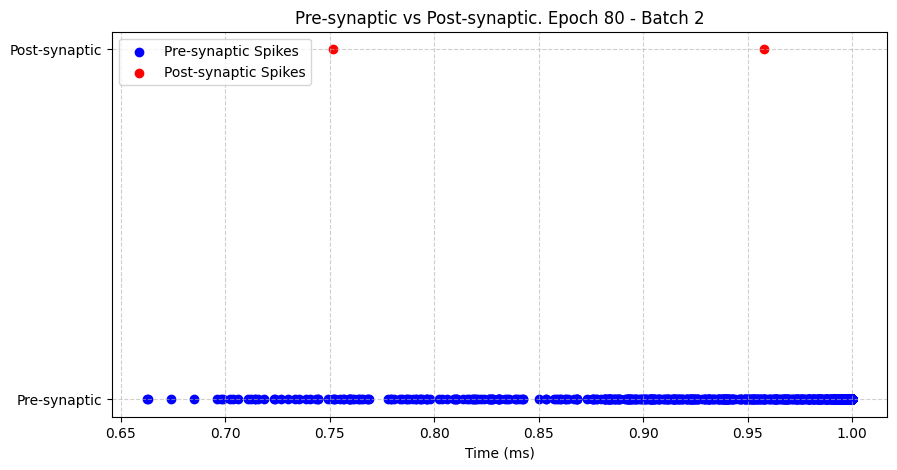

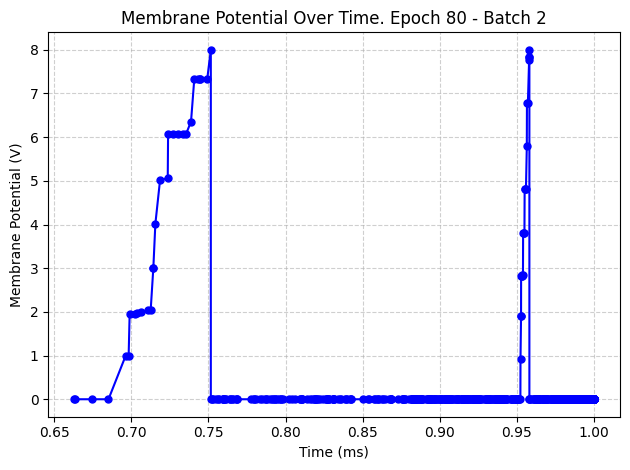

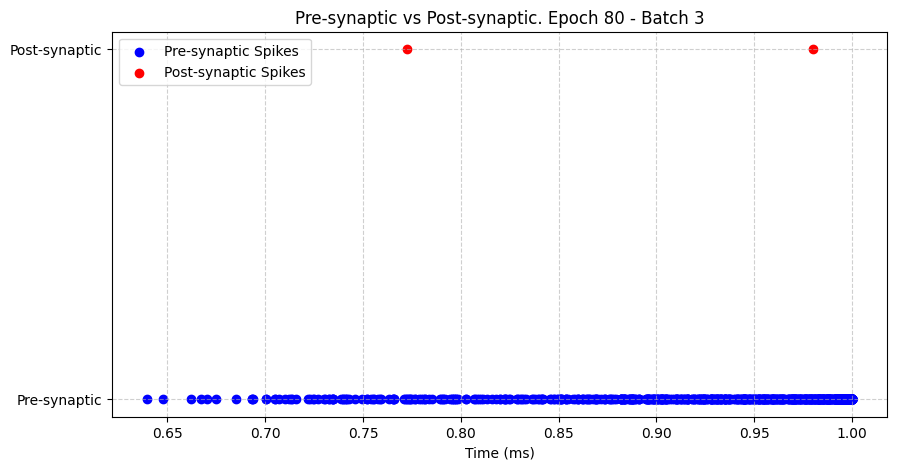

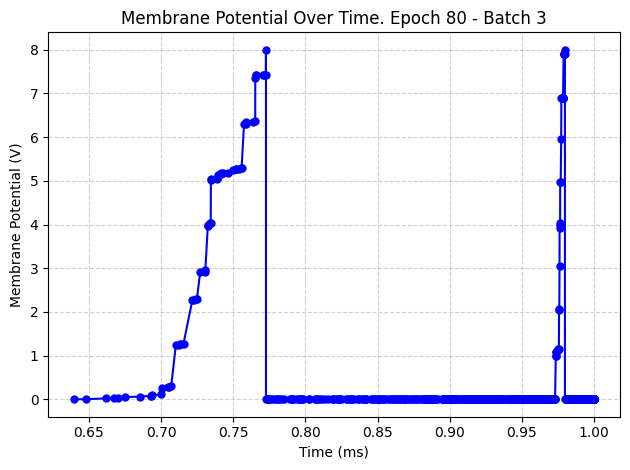

In [8]:
num_epochs = 80
if_neuron = IntegrateAndFireNeuron(threshold=8.0, refractory_period=0.2, num_inputs=max_input_spikes)
stdp = STDP()

for epoch_idx in range(1, num_epochs + 1):
    for batch_idx, (spikes, label, times) in enumerate(dataloader.iterate(batch_size=1), start=1):        
        membrane_potentials = []
        membrane_potentials_times = []
        
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
            output_spike = if_neuron.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
            
            if output_spike == 1.0:
                membrane_potentials.append(if_neuron.threshold)
                membrane_potentials_times.append(current_time)
            membrane_potentials.append(if_neuron.membrane_potential)
            membrane_potentials_times.append(current_time)
        
        pre_spike_times = times.flatten()
        if_neuron.backward(pre_spike_times, stdp)
        post_spike_times = if_neuron.spike_times

        if epoch_idx % 10 == 0 and batch_idx <= 3:
            SpikesVisualization.plot_pre_post_spikes(pre_spike_times, post_spike_times, title=f"Pre-synaptic vs Post-synaptic. Epoch {epoch_idx} - Batch {batch_idx}")
            SpikesVisualization.plot_membrane_potentials(membrane_potentials, membrane_potentials_times, title=f"Membrane Potential Over Time. Epoch {epoch_idx} - Batch {batch_idx}")
        
        if_neuron.reset()